In [1]:
print('hey',1)

hey 1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib import cm
import numba
from numba import jit

The spatiotemporal change for a species over time  can be written as

$$ \frac{\partial \rho}{\partial t} = D \nabla^2 \rho + \alpha(\vec{r}) \rho  - \beta \rho^2$$

where $\rho(\vec{r}, t)$ is the density (in numbers) of a species at position $\vec{r}$ and time $t$. Also specified is $\rho(\vec{r}, 0)$, the distribution of species at the initial time.

* **first term** on the RHS represents the diffusion of a species (i.e. a group of animals spreading out over some biome) with $D$ as the diffusion rate.
* **second term** on RHS is the growth of the species with $\alpha(\vec{r})$ as the abundance of resources at point $\vec{r}$.
* **third term** on RHS represents the death of the species, both through natural causes and from competition between orgamisms.

when multiplying by $\beta$, one obtains this equation (all parameters follow from above):

$$ \frac{\partial u}{\partial t} = D \nabla^2 u + \alpha(\vec{r}) u  - u^2$$

and in one dimension:

$$ \frac{\partial u}{\partial t} = d \frac{\partial^2 u}{\partial x^2} + u(r(x)  - u)$$

Now suppose there are two species with normalized densities $u$ and $v$. The equation above can be adjusted by adding two new values $a$ and $b$: the relative competing strengths of each species. Note that if $a < b$ then species 1 is better at outcompeting species 2. The equations are given by

$$ \frac{\partial u}{\partial t} = d_1 \frac{\partial^2 u}{\partial x^2} + u(r(x) - u  - av) $$

$$ \frac{\partial v}{\partial t} = d_2 \frac{\partial^2 v}{\partial x^2} + v(r(x) - bu  - v) $$

with initial conditions $u(x, 0) = f(x)$ and $v(x, 0) = g(x)$



#### The Question:

What makes one species better at outcompeting another species given a closed boundary with a zero flux condition? (i.e. finite area and animals cannot leave the area). Things to keep in mind

* $a$ and $b$
* $d_1$ and $d_2$
* $f(x)$ and $g(x)$

#### The Finite Difference method

Instead of using $dx$ and $dt$, we make a finite approximation with $\Delta x$ and $\Delta t$, leading to

$$u_i^{m+1} = u_i^m + \frac{d_1 \Delta t}{\Delta x^2} \left( u_{i+1}^m + u_{i-1}^m - 2u_{i}^m \right) + u_i^m \left(r_i - u_i^m - a v_i^m \right) \Delta t$$

$$v_i^{m+1} = v_i^m + \frac{d_2 \Delta t}{\Delta x^2} \left( v_{i+1}^m + v_{i-1}^m - 2v_{i}^m \right) + v_i^m \left(r_i - v_i^m - b u_i^m \right) \Delta t$$

In [2]:
times = np.linspace(0, 140, 200000)

In [3]:
config = 4

if config==1:
    # CONFIG 1 (first one to resources becomes majority)
    times = np.linspace(0, 140, 200000)
    x = np.linspace(-2, 2, 60)
    p1 = np.zeros([len(times), len(x)])
    p2 = np.zeros([len(times), len(x)])
    r = np.exp(-x**2/0.1)
    p1[0] = np.exp(-(x-1)**2/0.02)
    p2[0] = np.exp(-(x+1.2)**2/0.02)
    d1 = 0.01
    d2 = 0.01
    a = 1
    b = 1

elif config==2:
    # CONFIG 2 (seems like u2 gonna win but then u1 comes back)
    times = np.linspace(0, 140, 200000)
    x = np.linspace(-2, 2, 60)
    p1 = np.zeros([len(times), len(x)])
    p2 = np.zeros([len(times), len(x)])
    r = np.exp(-x**2/0.1)
    p1[0] = np.exp(-(x-1.2)**2/0.02)
    p2[0] = np.exp(-(x+1.2)**2/0.02)
    d1 = 0.001
    d2 = 0.01
    a = 1
    b = 1


elif config==3:
    # CONFIG 3 (selective advantage will win)
    times = np.linspace(0, 140, 200000)
    x = np.linspace(-2, 2, 60)
    p1 = np.zeros([len(times), len(x)])
    p2 = np.zeros([len(times), len(x)])
    r = np.exp(-x**2/0.1)
    p1[0] = np.exp(-(x-1.2)**2/0.02)
    p2[0] = np.exp(-(x+1.2)**2/0.02)
    d1 = 0.01
    d2 = 0.01
    a = 1
    b = 0.5
    
elif config==4:
    # CONFIG 4 (mixture)
    times = np.linspace(0, 140, 200000)
    x = np.linspace(-2, 2, 60)
    p1 = np.zeros([len(times), len(x)])
    p2 = np.zeros([len(times), len(x)])
    r = np.exp(-x**2/0.1)
    p1[0] = np.exp(-(x-1.2)**2/0.02)
    p2[0] = np.exp(-(x+1.2)**2/0.02)
    d1 = 0.01
    d2 = 0.1
    a = 1
    b = 0.5


dt = np.diff(times)[0]
dx = np.diff(x)[0]

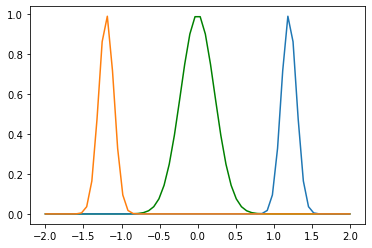

In [4]:
plt.plot(x, r, color='green')
plt.plot(x, p1[0])
plt.plot(x, p2[0])

In [5]:
dt/dx**2

0.15229451147255718

Apply the finite difference method:

In [8]:
@numba.jit("UniTuple(f8[:,:], 2)(f8[:,:], f8[:,:], f8[:])", nopython=True, nogil=True)
def solve_pop(p1, p2, r):
    for t in range(0,len(times)-1):
        for i in range(0, len(p1[0])):
            # Insulated Boundary Conditions
            if i==0:
                deriv2_1 = 2*p1[t][i+1] - 2*p1[t][i]
                deriv2_2 = 2*p2[t][i+1] - 2*p2[t][i]
            elif i==len(p1[0])-1:
                deriv2_1 =  2*p1[t][i-1] - 2*p1[t][i]
                deriv2_2 =  2*p2[t][i-1] - 2*p2[t][i]
            else:
                deriv2_1 = p1[t][i+1] + p1[t][i-1] - 2*p1[t][i]
                deriv2_2 = p2[t][i+1] + p2[t][i-1] - 2*p2[t][i]
                
            p1[t+1][i] = p1[t][i] + d1*dt/dx**2 * deriv2_1 + \
                         p1[t][i] * dt * (r[i] - p1[t][i] - a*p2[t][i])
            p2[t+1][i] = p2[t][i] + d2*dt/dx**2 * deriv2_2 + \
                         p2[t][i] * dt * (r[i] - p2[t][i] - b*p1[t][i])
            
    return p1, p2

In [9]:
p1, p2 = solve_pop(p1, p2, r)

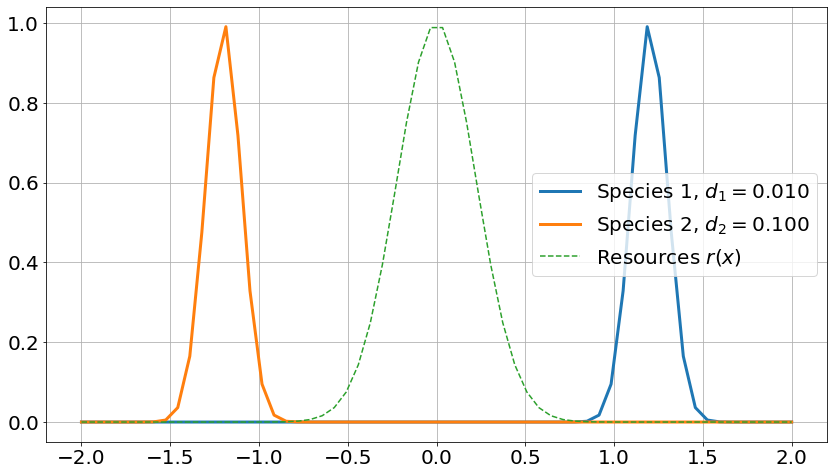

In [75]:
i= 0
plt.figure(figsize=(14,8))
plt.plot(x,p1[i], lw=3, label='Species 1, $d_1=${:.3f}'.format(d1))
plt.plot(x,p2[i], lw=3, label='Species 2, $d_2=${:.3f}'.format(d2))
plt.plot(x,r, ls='--', label='Resources $r(x)$')
plt.legend(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid()

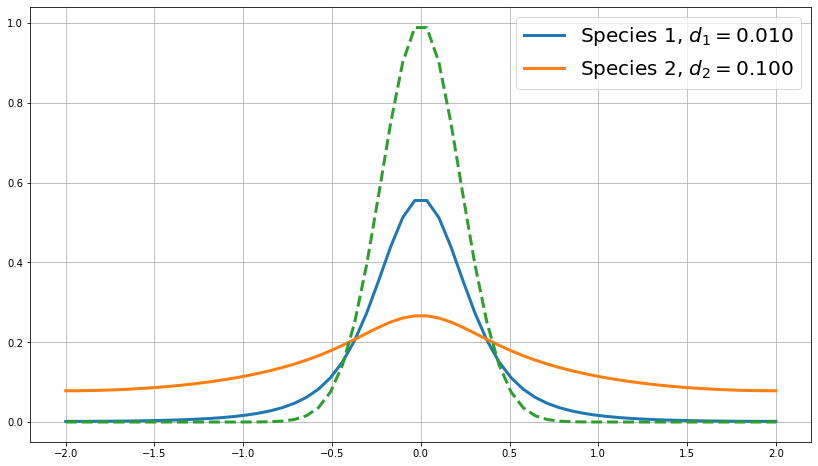

In [76]:
def animate(i):
    line1.set_data(x,p1[500*i])
    line2.set_data(x,p2[500*i])
    line3.set_data(x,r)
    
# Equal aspect ratio Figure with black background and no axes.
fig, ax = plt.subplots(1, 1, figsize=(14,8))
ax.grid()
line1, = ax.plot(x, p1[0], lw=3, label='Species 1, $d_1=${:.3f}'.format(d1))
line2, = ax.plot(x, p2[0], lw=3, label='Species 2, $d_2=${:.3f}'.format(d2))
line3, = ax.plot(x, r, ls='--', lw=3)
ax.legend(fontsize=20)

ani = animation.FuncAnimation(fig, animate, frames=399, interval=50)
ani.save('../../output/species.gif',writer='pillow',fps=10)